## Notebook implementation: High-dimensional statistical arbitrage with factor models and stochastic control
### Paper author: Jorge Guijarro-Ordonez

This notebook is based on the above mentioned paper

In [119]:
import numpy as np
from scipy.linalg import eig, inv, cholesky
from OU_simulation import *
import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2

### Part 1: Monte carlo simulations of high dimensional Ornstein-Uhlenbeck processes

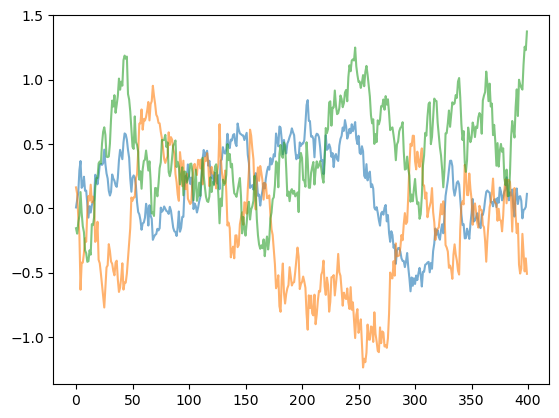

In [207]:
# Same parameters are used as in the paper 
N       = 3
T       = 20
L       = 400
delta_t = T/L
theta   = np.diag(np.random.normal(0.5, 0.1, N))
mu      = np.zeros((N,1))
sigma   = np.random.uniform(-0.3,0.3,(N,N))
sigma   = sigma - np.diag(sigma.diagonal()) + np.diag(np.random.uniform(0,0.5,N))

# Initialise the process
process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
X       = np.zeros((N,L))
Y       = np.zeros((N,L))

# Perform a monte carlo simulation
for idx in range(L):
    X[:,idx] = process.step()
    Y[:,idx] = process.Yt
plt.plot(np.transpose(X),alpha=0.6)
plt.show()

In [202]:
process.Lambda

array([[0.58872659, 0.        , 0.        ],
       [0.        , 0.51922048, 0.        ],
       [0.        , 0.        , 0.45406   ]])

In [203]:
sigma

array([[ 0.10396395, -0.16601961,  0.18854946],
       [ 0.11906144,  0.10623515, -0.13735077],
       [ 0.20287892, -0.21589801,  0.0931622 ]])

In [208]:
process.Var

array([[ 0.11609186, -0.13300969,  0.09089942],
       [-0.13300969,  0.31615144, -0.18501838],
       [ 0.09089942, -0.18501838,  0.28396316]])